# Features Engineering

## Continuous Numeric Data

### Binarization

根据指定的阈值将特征分为0或者1

In [1]:
# 使用 pandas 创建 DataFrame
import pandas as pd
from IPython.display import display

df = pd.DataFrame()
df['listen_count'] = [10, 0, 1, 22, 8]

display(df)

,listen_count
0,10
1,0
2,1
3,22
4,8


In [2]:
from sklearn.preprocessing import Binarizer

# 这里的阈值 threshold 设置为 0.9
# 是因为 判断条件为: if > 0.9 then 1; if <= 0.9 then 0
bn = Binarizer(threshold=0.9)
pd_watched = bn.transform([df['listen_count']])[0]
pd_watched

array([1, 0, 1, 1, 1])

### Rounding

有时特征的原始值（raw value）精度很高，比如：0.98746，对分析用处不大，此时可以降低其精度

In [3]:
import pandas as dp
import numpy as np

df = dp.DataFrame()
df['top_percent'] = np.random.rand(5)
df['popularity_scale_10'] = np.array(np.round(df['top_percent'] * 10), dtype='int') # 取值范围在1-10
df['popularity_scale_100'] = np.array(np.round(df['top_percent'] * 100), dtype='int') # 取值范围在1-100
df

,top_percent,popularity_scale_10,popularity_scale_100
0,0.808640,8,81
1,0.896155,9,90
2,0.074588,1,7
3,0.789677,8,79
4,0.296076,3,30


### Interactions

相互作用，指的是：在监督学习模型中，通常将特征作为输入值，将标签（目标）作为输出值，从而建立一个函数。比如线性回（linear regression）归等式可以表示为：

$y=c_1x_1+c_2x_2+\cdots+c_nx_n$

- $y$ 表示输出值，即标签（目标）
- ${x_1,x_2,\cdots,x_n}$ 表示特征
- ${c_1,c_2,\cdots,c_n}$ 表示权重（weights）或系数（conefficients）

在这种情况下，这个简单的线性模型表示的是输入值和输出值的关系，纯粹基于单独的输入特征。

然而，在现实环境中，尝试和捕获这些特征间的相互作用作为输入特征是很具有意义的。用上面线性回归公式结合相互作用的特征可以简单的进行扩展

$y=c_1x_1+c_2x_2+\cdots+c_nx_n+c_{11}x_1^2+c_{12}x_2^2+\cdots$

#### Polynomial Features

多项式特征，它属于 Derived Features 中的一种，所谓 Derived Features 直译为派生特征，实际就是根据已有特征派生出新的特征。多项式特征就是其中典型的用法。

对于派生特征本身不难理解，就是用数据集中原有的特征，经过某些计算得到一些新的特征，比如采用多项式的方法（关于多项式的算法这里不再赘述，具体可参考[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)），但是不容易的理解的是，为什么要派生特征，特别是为什么要使用多项式方法派生特征，他到底基于什么考虑呢？

通过下面的例子大体可以理解。这里先用一句话来概述：通过二项式特征派生，可以使用线性回归模型来解决二项式分布的数据。即无需更换模型（线性回归模型），仅需要对数据进行调整即可满足原模型（这里指线性回归模型）

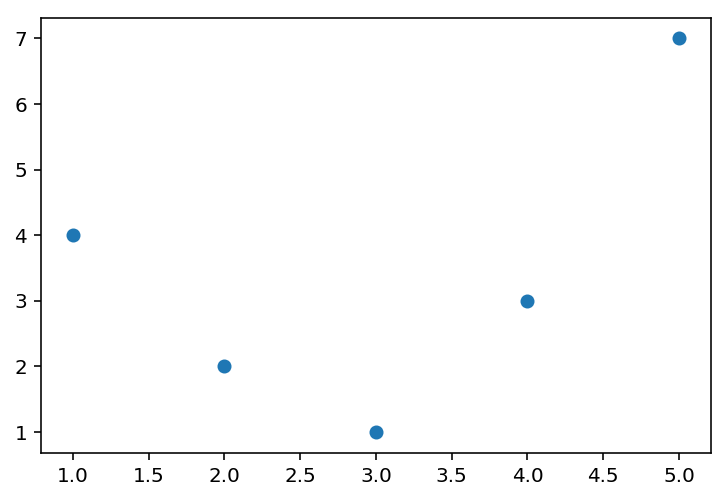

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

上面的图显示 x 和 y 的散点关系图

我们采用 LinearRegression 模型来为其建模

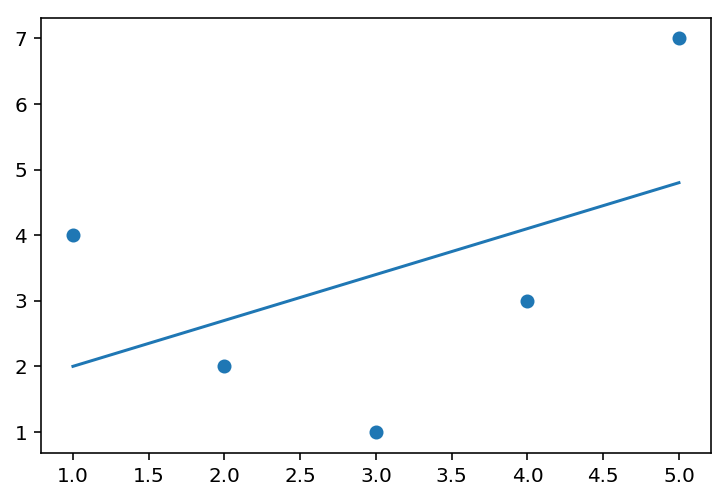

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
y_fit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, y_fit)

从上图很容易看出，直线很难满足数据间的关系，这时，我们可以采用 polynomial 方法来派生新的特征

In [14]:
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
X2

array([[  1.,   1.,   1.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.],
       [  5.,  25., 125.]])

现在用 polynomial features 方法派生出来新特征的 X2 特征集来训练 linear regression 模型

In [0]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

model = LinearRegression().fit(X2, y)
y_fit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, y_fit)

#### sklearn.preprocessing.PolynomialFeatures

这里解释一下`sklearn.preprocessing.PolynomialFeatures`API 的用法

> 官方文档解释：Generator polynomial and interaction features  
> 比如二维数据[a, b], the degree-2 polynomial features is $[1, a, b, a^2, ab, b^2]$

### Binning

分箱。将 continuous numeric features 分到不同的分类中。比如将年龄分为老、中、青，将收入分为低收入、中等收入、高收入等。

binning 可以分为如下两类：

- fixed-width binning
- adaptive binnig

#### Fixed-width binning

人为的设定分箱标准。

以下用 `./data/2016-FCC-New-Coders-Survey-Data.csv` 数据集为例来进行理解

In [0]:
import pandas as pd
from IPython.display import display

fcc_df = pd.read_csv('./data/2016-FCC-New-Coders-Survey-Data.csv', encoding='utf-8')

display(fcc_df.describe())
fcc_df[['ID.x', 'EmploymentField', 'Age', 'Income']].head()

这里先着重分析以下 Age 特征。首先通过图表的方式来看看 Age 特征的情况

In [0]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
fcc_df['Age'].hist(edgecolor='black', grid=False)
ax.set_title('Developer Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

如果我们想以下面的方式划分年龄

```
Age Range : Bin
----------------
 0 -  15   : 1
16 -  30   : 2
31 -  45   : 3
46 -  60   : 4
61 -  75   : 5
75 - 100   : 6
```

In [0]:
import numpy as np

bin_range = [0, 15, 30, 45, 60, 75, 100]
bin_names = [1, 2, 3, 4, 5, 6]

fcc_df['Age_bin_custom_range'] = pd.cut(np.array(fcc_df['Age']), bins=bin_range)
fcc_df['Age_bin_custom_label'] = pd.cut(np.array(fcc_df['Age']), bins=bin_range, labels=bin_names)

fcc_df[['ID.x', 'Age', 'Age_bin_custom_range', 'Age_bin_custom_label']].iloc[1071: 1076]

#### Adaptive binning

根据数据自身的特征自动分箱。通常可分为 2-quantiles 也称之为 *median* ，4-quantiles 也称之为 *quartile* ，10-quantiles 也称之为 *deciles*

In [0]:
fig, ax = plt.subplots()
fcc_df['Income'].hist(bins=30, edgecolor='black', grid=False)
ax.set_title('Developer Income Histogram', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)